In [4]:
import yaml
import argparse
import os
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# From local helper files
from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_caltech101

In [6]:
##########################
### SETTINGS
##########################
parser = argparse.ArgumentParser()
parser.add_argument('--settings_path',
                    type=str,
                    default='./config_test1.yaml',
                    help='Path to the YAML config file')
parser.add_argument('--results_path',
                    type=str,
                    default='./results',
                    help='Folder where results are saved')

args, unknown = parser.parse_known_args() # Ignore unknown arguments

# Create results folder if doesn't exist
if not os.path.exists(args.results_path):
    os.makedirs(args.results_path)

# Load YAML settings
with open(args.settings_path, 'r') as file:
    SETTINGS = yaml.load(file, Loader=yaml.FullLoader)

if torch.cuda.is_available():
    DEVICE = torch.device(f"cuda:{SETTINGS.get('cuda_device', 0)}")
else:
    DEVICE = torch.device('cpu')

# Set random seeds, etc.
set_all_seeds(SETTINGS['random_seed'])
# set_deterministic

In [7]:
##########################
### DATASET & DATALOADERS
##########################
resize_transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda image: image.convert('RGB')),
    torchvision.transforms.RandomCrop(32),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_loader, valid_loader, test_loader = get_dataloaders_caltech101(
    batch_size=SETTINGS['batch_size'],
    validation_fraction=SETTINGS['validation_percent'],
    train_transforms=resize_transform,
    test_transforms=resize_transform
)

##########################
### MODEL DEFINITION
##########################

model = nn.Sequential(
    # (1) First Convolutional Block
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),

    # (2) Second Convolutional Block
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=1, padding=1),

     # (3) Third Convolutional Block
    nn.Conv2d(in_channels=128, out_channels=32, kernel_size=1, stride=1, padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=1, stride=1),

    # (4) Flatten the output of the conv layers
    nn.Flatten(),
    # (5) Fully Connected Layer + Activation
    nn.Dropout(p=0.5),
    nn.Linear(in_features=32 * 8 * 8, out_features=512),
    nn.ReLU(),
    # (6) Final Output Layer
    nn.Linear(in_features=512, out_features=SETTINGS['num_classes'])
)

model.to(SETTINGS['cuda_device'])


##########################
### WEIGHT INITIALIZATION
##########################
def apply_weight_init(model, init_name='none'):
    """
    Apply weight initialization to Conv2d and Linear layers
    within an nn.Sequential model.
    """
    for layer in model:
        if isinstance(layer, (nn.Conv2d, nn.Linear)):
            if init_name == 'xavier_uniform':
                nn.init.xavier_uniform_(layer.weight)
                nn.init.constant_(layer.bias, 0.0)
            elif init_name == 'kaiming_normal':
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.constant_(layer.bias, 0.0)
            elif init_name == 'orthogonal':
                nn.init.orthogonal_(layer.weight)
                nn.init.constant_(layer.bias, 0.0)
            else:
                # If none or unknown, just leave PyTorch default
                pass

# Read weight init scheme from config
weight_init_config = SETTINGS.get('weight_init', {})
weight_init_name = weight_init_config.get('name', 'none')

apply_weight_init(model, init_name=weight_init_name)

##########################
### OPTIMIZER
##########################
optimizer_config = SETTINGS.get('optimizer', {})
optimizer_name   = optimizer_config.get('name', 'SGD')  # default to 'SGD'

if optimizer_name == 'SGD':
    momentum = float(optimizer_config.get('momentum', 0.0))
    weight_decay = float(optimizer_config.get('weight_decay', 0.0))
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=SETTINGS['learning_rate'],
        momentum=momentum,
        weight_decay=weight_decay
    )
elif optimizer_name == 'Adam':
    weight_decay = float(optimizer_config.get('weight_decay', 0.0))
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=SETTINGS['learning_rate'],
        weight_decay=weight_decay
    )
else:
    raise ValueError(f"Unknown optimizer: {optimizer_name}")

##########################
### LR SCHEDULER
##########################
scheduler_config = SETTINGS.get('scheduler', {})
scheduler_name   = scheduler_config.get('name', 'None')

# Default to ReduceLROnPlateau, if not specified
if scheduler_name == 'ReduceLROnPlateau':
    factor   = scheduler_config.get('factor', 0.1)
    mode     = scheduler_config.get('mode', 'max')
    patience = scheduler_config.get('patience', 5)
    verbose  = scheduler_config.get('verbose', True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=factor,
        mode=mode,
        patience=patience,
    )
elif scheduler_name == 'ExponentialLR':
    gamma = scheduler_config.get('gamma', 0.99)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
elif scheduler_name == 'StepLR':
    step_size = scheduler_config.get('step_size', 30)
    gamma = scheduler_config.get('gamma', 0.1)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
elif scheduler_name.lower() == 'none':
    scheduler = None
else:
    raise ValueError(f"Unknown scheduler: {scheduler_name}")

Files already downloaded and verified


Epoch: 001/100 | Batch 0000/0008 | Loss: 5.9159
Epoch: 001/100 | Train: 4.57% | Validation: 7.16%
Time elapsed: 0.38 min
Epoch: 002/100 | Batch 0000/0008 | Loss: 4.9846
Epoch: 002/100 | Train: 9.06% | Validation: 11.32%
Time elapsed: 0.79 min
Epoch: 003/100 | Batch 0000/0008 | Loss: 4.5264
Epoch: 003/100 | Train: 9.22% | Validation: 11.78%
Time elapsed: 1.18 min
Epoch: 004/100 | Batch 0000/0008 | Loss: 4.4046
Epoch: 004/100 | Train: 9.17% | Validation: 12.47%
Time elapsed: 1.58 min
Epoch: 005/100 | Batch 0000/0008 | Loss: 4.3621
Epoch: 005/100 | Train: 9.38% | Validation: 12.01%
Time elapsed: 1.98 min
Epoch: 006/100 | Batch 0000/0008 | Loss: 4.3510
Epoch: 006/100 | Train: 9.97% | Validation: 13.63%
Time elapsed: 2.38 min
Epoch: 007/100 | Batch 0000/0008 | Loss: 4.3153
Epoch: 007/100 | Train: 10.63% | Validation: 13.16%
Time elapsed: 2.72 min
Epoch: 008/100 | Batch 0000/0008 | Loss: 4.3299
Epoch: 008/100 | Train: 11.32% | Validation: 16.17%
Time elapsed: 3.07 min
Epoch: 009/100 | Batch 

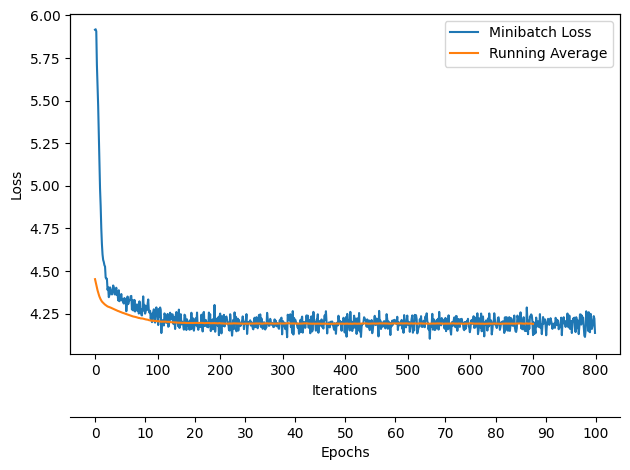

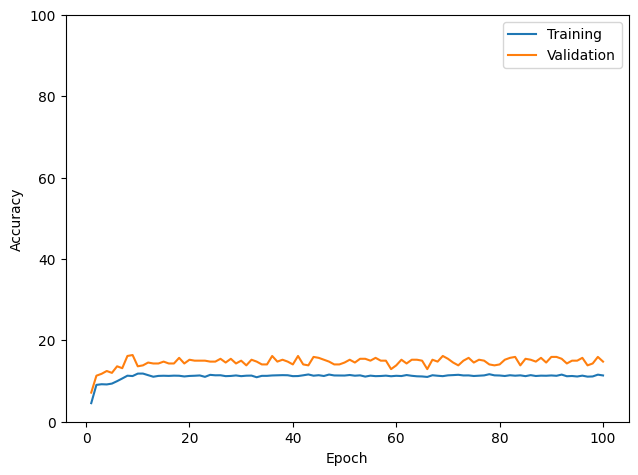

In [8]:
##########################
### TRAINING LOOP
##########################
# The helper_train.py presumably expects scheduler if not None,
# and you might specify how it’s applied (e.g., 'valid_acc').
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=SETTINGS['num_epochs'],
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=SETTINGS['cuda_device'],
    logging_interval=100,
    scheduler=scheduler,
    scheduler_on='valid_acc'  # or 'train_acc' or 'valid_loss'
)

##########################
### PLOTTING
##########################
plot_training_loss(
    minibatch_loss_list=minibatch_loss_list,
    num_epochs=SETTINGS['num_epochs'],
    iter_per_epoch=len(train_loader),
    results_dir=None,
    averaging_iterations=100
)
plt.show()

plot_accuracy(
    train_acc_list=train_acc_list,
    valid_acc_list=valid_acc_list,
    results_dir=None
)
plt.ylim([0, 100])
plt.show()

In [9]:
from torchsummary import summary

summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]           1,792
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 128, 7, 7]           8,320
              ReLU-5            [-1, 128, 7, 7]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7             [-1, 32, 8, 8]           4,128
              ReLU-8             [-1, 32, 8, 8]               0
         MaxPool2d-9             [-1, 32, 8, 8]               0
          Flatten-10                 [-1, 2048]               0
          Dropout-11                 [-1, 2048]               0
           Linear-12                  [-1, 512]       1,049,088
             ReLU-13                  [-1, 512]               0
           Linear-14                  [